In [3]:
import pandas as pd
import numpy as np
import json
import pickle

# Gensim libraries:
import gensim
from gensim import corpora
from gensim.corpora import Dictionary, MmCorpus
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel, LdaMulticore
import pyLDAvis
from pyLDAvis import gensim_models as gensimvis
pyLDAvis.enable_notebook()
from pprint import pprint

# NLTK:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')



# Matplotlib:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

# Word-cloud:
from wordcloud import WordCloud, STOPWORDS

#### 1. Read the dataset:
Here we read the dataset that we have annotated with Vader, nrc and moralstrength. The idea is to add the topic scores besides the other lyrics features scores

In [2]:
artist_lyrics_audio_dt = pd.read_csv('../Data/Artist_Tracks_Lyrics_Audio_Features/English_artist_5_tracks_with_lyrics_vader_nrc_moralStrength_and_sp_features.csv')
print(artist_lyrics_audio_dt.shape)
artist_lyrics_audio_dt.head(5)

(30820, 144)


,Artist,Artist_cleaned_name,track_title,track_spotify_id,original_lyrics,cleaned_lyrics,lang_detect_spacy,words,lemmas,word_counts,...,album_release_date,track_duration,track_popularity,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
0,Nsync,Nsync,Bye Bye Bye,62bOmKYxYg7dhrC6gH9vFn,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...","Hey, hey Bye bye bye Bye bye! Bye bye! I'm ...",en,"['hey', 'hey', 'bye', 'bye', 'bye', 'bye', 'by...","['tonight', 'probably', 'going', 'start', 'fig...",409,...,2000-03-21,200400.0,71.0,0.03100,0.610,0.926,0.001200,0.0821,0.0479,0.861
1,Nsync,Nsync,It’s Gonna Be Me,2AW37v0bDyuOzGP3XnmFuA,[Intro: Justin]\n(It's gonna be me)\nOooh yeah...,"Oooh yeah You might've been hurt, babe That ...",en,"['oooh', 'yeah', 'you', 'might', 've', 'been',...","['hurt', 'babe', 'lie', 'see', 'come', 'go', '...",292,...,2000-03-21,192427.0,68.0,0.04070,0.636,0.873,0.000001,0.0372,0.0710,0.908
2,Nsync,Nsync,Tearin’ Up My Heart,73q3FpQVXWk5eSUnyo83E4,[Chorus: JC & Justin]\nIt's tearin' up my hear...,It's tearin' up my heart when I'm with you But...,en,"['it', 's', 'tearin', 'up', 'my', 'heart', 'wh...","['tearin', 'heart', 'apart', 'feel', 'matter',...",315,...,1997,209400.0,66.0,0.00211,0.687,0.918,0.000013,0.3440,0.0392,0.747
3,Nsync,Nsync,Gone,4CCUjYJPbSXLL23BFeBVbI,[Verse 1: Justin]\nThere's a thousand words th...,There's a thousand words that I could say To m...,en,"['there', 's', 'a', 'thousand', 'words', 'that...","['word', 'say', 'make', 'come', 'home', 'seem'...",472,...,2001-07-24,292000.0,53.0,0.43000,0.704,0.409,0.000000,0.1090,0.0597,0.495
4,Nsync,Nsync,"Merry Christmas, Happy Holidays",4v9WbaxW8HdjqfUiWYWsII,"[Intro: Justin, All & JC]\nOooh, ooh ooh\nMerr...","Oooh, ooh ooh Merry Christmas Happy holidays M...",en,"['oooh', 'ooh', 'ooh', 'merry', 'christmas', '...","['wait', 'year', 'night', 'snow', 'glisten', '...",372,...,1998-10-30,255307.0,50.0,0.10400,0.643,0.939,0.000000,0.8810,0.0463,0.756


#### Preprocessing Step:
We skip preprocessing step and just read the lemmas we saved from when we extracted other lyrics features (see point 6 in *lyrics_vader_nrc_moral_strength_annotations.ipynb*). Instead, we just read the lemmas of each song from the json file.

In [3]:
with open('../../Data/Artist_Tracks_Lyrics_Audio_Features/en_5_tracks_lyrics_lemmas') as f:
    lyrics_spacy_lemmas = json.load(f)

In [4]:
len(lyrics_spacy_lemmas)

30820

In [6]:
extended_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'mmm', 'oooh','yah',
                      'yeh','mmm', 'hmm','deh','doh','jah','wa', 'dem', 'ohoh', 'nah',
                      'yuh', 'doo', 'boom' ,'doo', 'oohooh', 'get', 'know', 'la']

stopwords.extend(extended_stop_words)



In [7]:
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [8]:
def remove_stop_words(lemmatized_list):
    # We put here some words that also represents ambiguity in topic modelling:
    
    # Clean stopwords for lemmas:
    lemmas_without_stopwords = []
    lemmas_length_ws = []
    for song in lemmatized_list:
        filtered_text = []    
        for token in song:
            if token not in stopwords and (not token.isnumeric()):
                filtered_text.append(token)
        lemmas_without_stopwords.append(filtered_text)
        lemmas_length_ws.append(len(filtered_text))
    
    return lemmas_without_stopwords, lemmas_length_ws

In [9]:
lyrics_spacy_lemmas, lemma_length = remove_stop_words(lyrics_spacy_lemmas)

In [10]:
lyrics_spacy_lemmas

[['tonight',
  'probably',
  'going',
  'start',
  'fight',
  'right',
  'baby',
  'come',
  'love',
  'endlessly',
  'time',
  'leave',
  'make',
  'alone',
  'take',
  'lie',
  'wanna',
  'see',
  'door',
  'baby',
  'wanna',
  'fool',
  'player',
  'game',
  'hate',
  'lie',
  'baby',
  'really',
  'wanna',
  'make',
  'tough',
  'tell',
  'enough',
  'sound',
  'crazy',
  'lie',
  'baby',
  'hit',
  'truth',
  'girl',
  'welcome',
  'give',
  'good',
  'reason',
  'baby',
  'come',
  'live',
  'really',
  'come',
  'see',
  'life',
  'much',
  'well',
  'go',
  'take',
  'lie',
  'wanna',
  'see',
  'door',
  'baby',
  'wanna',
  'fool',
  'player',
  'game',
  'hate',
  'lie',
  'baby',
  'really',
  'wanna',
  'make',
  'tough',
  'tell',
  'enough',
  'sound',
  'crazy',
  'lie',
  'baby',
  'give',
  'sure',
  'wanna',
  'reason',
  'love',
  'checkin',
  'signin',
  'want',
  'loser',
  'enough',
  'wanna',
  'fool',
  'game',
  'leave',
  'wanna',
  'make',
  'tough',
  'enou

#### 2. LDA Dictionary Creation and occurrence-based Filtering:
To perform Latent Dirichlet Allocation, the well-established Python library-gensim is used, which requires a dictionary representation of the documents. Meaning that all tokens are mapped to a unique ID, this reduces the overall dimensionality of a literature corpus. 

In [11]:
dictionary = corpora.Dictionary(lyrics_spacy_lemmas)
dictionary.filter_extremes(no_above = 0.9) #no_below = 100,

#### 3. Bag-of-Words and Index to Dictionary Conversion:
Each song (transformed in a list of tokens) is converted into the bag-of-words, which stores the unique token ID and its count for each song.

In [12]:
gensim_corpus = [dictionary.doc2bow(song) for song in lyrics_spacy_lemmas]
temp = dictionary[0]
# id2word = dictionary.id2token
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(gensim_corpus))
print(gensim_corpus[:1])

Number of unique tokens: 13961
Number of documents: 30820
[[(0, 1), (1, 9), (2, 1), (3, 3), (4, 3), (5, 2), (6, 1), (7, 5), (8, 1), (9, 5), (10, 4), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 2), (19, 9), (20, 1), (21, 1), (22, 1), (23, 2), (24, 5), (25, 1), (26, 3), (27, 1), (28, 4), (29, 2), (30, 1), (31, 3), (32, 1), (33, 3), (34, 1), (35, 1), (36, 2), (37, 3), (38, 1), (39, 1), (40, 4), (41, 1), (42, 12), (43, 1), (44, 1), (45, 1)]]


#### 4. Choosing the number of topics in LDA:
Here we find the optimal number of topics. We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

In [54]:
def compute_coherence_and_perplexity_values(dictionary, gensim_corpus,
                             lyrics_spacy_lemmas, limit, start=2, step=2):
    coherence_values = []
    u_mass_values = []
    perplexity_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=gensim_corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        
        # C_V:
        coherencemodel = CoherenceModel(model=model, texts=lyrics_spacy_lemmas, 
                                        dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        # U_mass:
        coherencemodel_u_mass = CoherenceModel(model=model, texts=lyrics_spacy_lemmas, 
                                               dictionary=dictionary, coherence="u_mass")
        u_mass_values.append(coherencemodel_u_mass.get_coherence())
        
        # Perplexity:
        perplexitymodel = model.log_perplexity(gensim_corpus)
        perplexity_values.append(perplexitymodel)


        
    return model_list, coherence_values, u_mass_values, perplexity_values

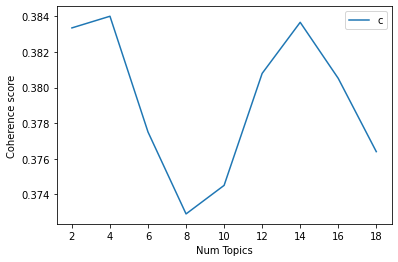

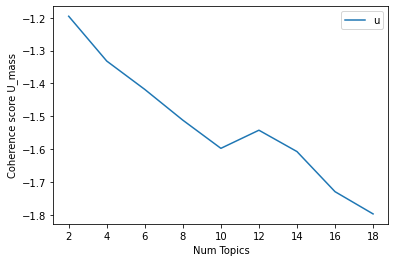

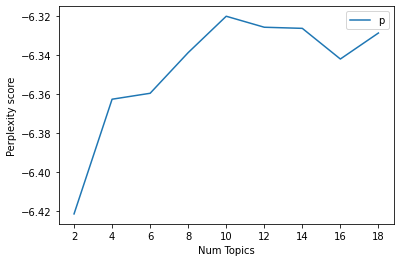

In [14]:
start=2;limit=20; step=2

model_list, coherence_values, u_mass_values, perplexity_values  = compute_coherence_and_perplexity_values(dictionary=dictionary, 
                            gensim_corpus=gensim_corpus, 
                            lyrics_spacy_lemmas=lyrics_spacy_lemmas, 
                            start=start, limit=limit, step=step)

x = range(start, limit, step)

# Show c_v graph
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Show u_mass graph
plt.plot(x, u_mass_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score U_mass")
plt.legend(("u_mass_values"), loc='best')
plt.show()



# Show perplexity graph
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

*4.1. The LDA model with the proposed number of k topics based on the coherence and perplexity estimations:*

In [114]:
chunksize = 200
passes = 10
iterations = 200
num_topics = 4
random_state = 200

lda_model = LdaModel(corpus=gensim_corpus,
                    id2word=dictionary,
                    chunksize=chunksize,
                    alpha='auto',
                    eta='auto',
                    iterations=iterations,
                    num_topics=num_topics,
                    passes=passes,
                    per_word_topics = True)

In [116]:
pprint(lda_model.print_topics())

[(0,
  '0.026*"girl" + 0.020*"come" + 0.018*"go" + 0.017*"baby" + 0.015*"going" + '
  '0.014*"little" + 0.013*"man" + 0.012*"like" + 0.011*"dance" + 0.010*"good"'),
 (1,
  '0.028*"love" + 0.023*"go" + 0.018*"feel" + 0.018*"never" + 0.018*"time" + '
  '0.016*"say" + 0.016*"want" + 0.014*"let" + 0.014*"see" + 0.014*"make"'),
 (2,
  '0.024*"fuck" + 0.018*"shit" + 0.012*"bitch" + 0.010*"hit" + 0.009*"make" + '
  '0.009*"money" + 0.007*"keep" + 0.006*"back" + 0.006*"put" + '
  '0.006*"fucking"'),
 (3,
  '0.009*"light" + 0.008*"eye" + 0.008*"burn" + 0.007*"life" + 0.007*"fire" + '
  '0.007*"world" + 0.007*"die" + 0.007*"see" + 0.006*"soul" + 0.006*"come"')]


In [61]:
coherencemodel = CoherenceModel(model=lda_model, texts=lyrics_spacy_lemmas, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

0.4120474438814593


#### We decided to keep 4 general topics for the song lyrics:
Based on the Coherence and Perplexity estimations 4-6 topics are the most suited for the song lyrics in our dataset. We tried multiple combinations and the most clear definition of the topis was for k=4. Feel free to try other k values (6, 8, etc).

We named our 4 topics as follows: 
**1. Time/Life:** We named this topic like this since it contains keywords as light, night, day, time, world, etc,that are related to living and have more neutral context; 
**2. Obscene:** This topic contains swearing and insulting words;
**3. Romantic:** This topic contains words related to love;
**Death/Fear/Violence:** This topic contains words related to war, death and darkness.

#### 5. Save the LDA model:

In [63]:
# with open("../../Data/LDA_Models/lda_model_best_k4.pk","wb") as f:
#     pickle.dump(lda_model, f)

*5.1.Read the best LDA model that we hace saved:*

In [13]:
with open('../../Data/LDA_Models/lda_model_best_k4.pk', 'rb') as pickle_file:
    lda_model= pickle.load(pickle_file)

In [14]:
 pprint(lda_model.print_topics())

[(0,
  '0.010*"lie" + 0.009*"die" + 0.009*"burn" + 0.008*"soul" + 0.008*"la" + '
  '0.008*"blood" + 0.007*"fire" + 0.007*"dead" + 0.006*"life" + 0.006*"man"'),
 (1,
  '0.018*"see" + 0.018*"come" + 0.016*"time" + 0.016*"go" + 0.014*"fall" + '
  '0.014*"away" + 0.013*"day" + 0.013*"night" + 0.012*"eye" + 0.012*"feel"'),
 (2,
  '0.038*"get" + 0.014*"fuck" + 0.010*"shit" + 0.008*"man" + 0.007*"bitch" + '
  '0.007*"back" + 0.007*"go" + 0.007*"hit" + 0.006*"come" + 0.006*"make"'),
 (3,
  '0.051*"know" + 0.038*"love" + 0.033*"get" + 0.024*"say" + 0.022*"want" + '
  '0.021*"go" + 0.019*"need" + 0.019*"make" + 0.018*"think" + 0.016*"let"')]


#### 6. Visualise the LDA model and save as .html file using pyLDAvis:

In [89]:
# vis_data = gensimvis.prepare(lda_model, gensim_corpus, dictionary)
# #pyLDAvis.display(vis_data)
# pyLDAvis.save_html(vis_data, '../../Data/LDA_Models/lyrics_lda_best_k_'+ str(num_topics) +'.html')


#### 7. The Dominant topic and its percentage contribution in each Lyrics
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The code below extracts the dominant topic for each lyrics and shows the weight of the topic and the keywords in a nicely formatted output. This way, we will know which lyrics belongs predominantly to which topic.

In [74]:
def format_topics_lyrics(ldamodel=None, corpus=gensim_corpus, texts=lyrics_spacy_lemmas):    
    lyrics_topics_dt = pd.DataFrame()

    # Get main topic in each lyrics
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list # assign weights per each lyrics rows          
      
        row = sorted(row, key=lambda x: (x[1]), reverse=True) #sorted rows based on the weights
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row): # topic num and propability
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num) # ('word', topic_pribablity)
                topic_keywords = ", ".join([word for word, prop in wp]) # join keywords per topic
                lyrics_topics_dt = lyrics_topics_dt.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    lyrics_topics_dt.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    lyrics_topics_dt = pd.concat([lyrics_topics_dt, contents], axis=1) #column wise
    return(lyrics_topics_dt)

In [75]:
topic_lyrics_keywords_dt = format_topics_lyrics(ldamodel = lda_model, 
                                                corpus = gensim_corpus, 
                                                texts = lyrics_spacy_lemmas)

In [76]:
topic_lyrics_keywords_dt

,dominant_topic,perc_contribution,topic_keywords,0
0,3.0,0.8537,"know, love, get, say, want, go, need, make, th...","[tonight, probably, going, start, fight, know,..."
1,3.0,0.8551,"know, love, get, say, want, go, need, make, th...","[hurt, babe, lie, see, come, go, remember, tel..."
2,3.0,0.6853,"know, love, get, say, want, go, need, make, th...","[tearin, heart, apart, feel, matter, feel, pai..."
3,3.0,0.6751,"know, love, get, say, want, go, need, make, th...","[word, say, make, come, home, seem, long, ago,..."
4,3.0,0.5663,"know, love, get, say, want, go, need, make, th...","[wait, year, night, snow, glisten, tree, outsi..."
...,...,...,...,...
30815,3.0,0.9104,"know, love, get, say, want, go, need, make, th...","[young, love, know, still, know, good, long, d..."
30816,3.0,0.5511,"know, love, get, say, want, go, need, make, th...","[spotlight, water, hit, run, extra, cold, shak..."
30817,1.0,0.5233,"see, come, time, go, fall, away, day, night, e...","[know, go, anywhere, girl, mood, know, get, lo..."
30818,3.0,0.7550,"know, love, get, say, want, go, need, make, th...","[outline, eye, vision, girl, think, need, minu..."


*7.1. Format dominant keyword dataframe*

In [77]:
dominant_topic_dt = topic_lyrics_keywords_dt.reset_index()
dominant_topic_dt.columns = ['document_no', 'dominant_topic', 'topic_contrib', 'keywords', 'lyrics']
dominant_topic_dt.reset_index(drop = True, inplace = True)
dominant_topic_dt[:10]

,document_no,dominant_topic,topic_contrib,keywords,lyrics
0,0,3.0,0.8537,"know, love, get, say, want, go, need, make, th...","[tonight, probably, going, start, fight, know,..."
1,1,3.0,0.8551,"know, love, get, say, want, go, need, make, th...","[hurt, babe, lie, see, come, go, remember, tel..."
2,2,3.0,0.6853,"know, love, get, say, want, go, need, make, th...","[tearin, heart, apart, feel, matter, feel, pai..."
3,3,3.0,0.6751,"know, love, get, say, want, go, need, make, th...","[word, say, make, come, home, seem, long, ago,..."
4,4,3.0,0.5663,"know, love, get, say, want, go, need, make, th...","[wait, year, night, snow, glisten, tree, outsi..."
5,5,1.0,0.5512,"see, come, time, go, fall, away, day, night, e...","[fill, set, free, today, feel, fall, sleep, wo..."
6,6,1.0,0.3949,"see, come, time, go, fall, away, day, night, e...","[sell, soul, make, right, tell, breathe, night..."
7,7,1.0,0.4488,"see, come, time, go, fall, away, day, night, e...","[bring, sun, head, look, fine, care, care, los..."
8,8,1.0,0.4254,"see, come, time, go, fall, away, day, night, e...","[look, face, feel, fire, eye, turn, blue, beli..."
9,9,1.0,0.6735,"see, come, time, go, fall, away, day, night, e...","[give, ever, expect, follow, feel, lone, fire,..."


In [82]:
dominant_topic_dt.dominant_topic.value_counts()

3.0    11875
1.0    10332
0.0     4468
2.0     4145
Name: dominant_topic, dtype: int64

*7.2. Let's add the topics to the rest of lyrics emotions and sentiment dataframe:*

In [83]:
dominant_topic_dt['dominant_topic'] = dominant_topic_dt['dominant_topic'].replace(0.0, 'death/fear/violence')
dominant_topic_dt['dominant_topic'] = dominant_topic_dt['dominant_topic'].replace(1.0, 'time/life')
dominant_topic_dt['dominant_topic'] = dominant_topic_dt['dominant_topic'].replace(3.0, 'romantic')
dominant_topic_dt['dominant_topic'] = dominant_topic_dt['dominant_topic'].replace(2.0, 'obscene')

#### 8. Concatenate the artist lyrics features dataset with the extracted topics: 

In [84]:
artist_lyrics_audio_dt = pd.concat([artist_lyrics_audio_dt,
                                                         dominant_topic_dt[['dominant_topic','topic_contrib']]], axis = 1)

In [85]:
print(artist_lyrics_audio_dt.shape)
artist_lyrics_audio_dt.head(3)

(30820, 146)


,Artist,Artist_cleaned_name,track_title,track_spotify_id,original_lyrics,cleaned_lyrics,lang_detect_spacy,words,lemmas,word_counts,...,track_popularity,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,dominant_topic,topic_contrib
0,Nsync,Nsync,Bye Bye Bye,62bOmKYxYg7dhrC6gH9vFn,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...","Hey, hey Bye bye bye Bye bye! Bye bye! I'm ...",en,"['hey', 'hey', 'bye', 'bye', 'bye', 'bye', 'by...","['tonight', 'probably', 'going', 'start', 'fig...",409,...,71.0,0.03100,0.610,0.926,0.001200,0.0821,0.0479,0.861,romantic,0.8537
1,Nsync,Nsync,It’s Gonna Be Me,2AW37v0bDyuOzGP3XnmFuA,[Intro: Justin]\n(It's gonna be me)\nOooh yeah...,"Oooh yeah You might've been hurt, babe That ...",en,"['oooh', 'yeah', 'you', 'might', 've', 'been',...","['hurt', 'babe', 'lie', 'see', 'come', 'go', '...",292,...,68.0,0.04070,0.636,0.873,0.000001,0.0372,0.0710,0.908,romantic,0.8551
2,Nsync,Nsync,Tearin’ Up My Heart,73q3FpQVXWk5eSUnyo83E4,[Chorus: JC & Justin]\nIt's tearin' up my hear...,It's tearin' up my heart when I'm with you But...,en,"['it', 's', 'tearin', 'up', 'my', 'heart', 'wh...","['tearin', 'heart', 'apart', 'feel', 'matter',...",315,...,66.0,0.00211,0.687,0.918,0.000013,0.3440,0.0392,0.747,romantic,0.6853


#### Now we apply one hot encoding for the topics:

In [86]:
one_hot_encoded_genre_topis = pd.get_dummies(
     artist_lyrics_audio_dt['dominant_topic'], prefix= None)
one_hot_encoded_genre_topis

,death/fear/violence,obscene,romantic,time/life
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
30815,0,0,1,0
30816,0,0,1,0
30817,0,0,0,1
30818,0,0,1,0


#### Now we concatenate this with the rest of the data audio and information:

In [87]:
artist_lyrics_audio_dt.reset_index(drop = True, inplace = True)
one_hot_encoded_genre_topis.reset_index(drop = True, inplace = True)

artist_lyrics_audio_dt = pd.concat([artist_lyrics_audio_dt, one_hot_encoded_genre_topis], axis = 1)

In [88]:
artist_lyrics_audio_dt.head()

,Artist,Artist_cleaned_name,track_title,track_spotify_id,original_lyrics,cleaned_lyrics,lang_detect_spacy,words,lemmas,word_counts,...,instrumentalness,liveness,speechiness,valence,dominant_topic,topic_contrib,death/fear/violence,obscene,romantic,time/life
0,Nsync,Nsync,Bye Bye Bye,62bOmKYxYg7dhrC6gH9vFn,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...","Hey, hey Bye bye bye Bye bye! Bye bye! I'm ...",en,"['hey', 'hey', 'bye', 'bye', 'bye', 'bye', 'by...","['tonight', 'probably', 'going', 'start', 'fig...",409,...,0.001200,0.0821,0.0479,0.861,romantic,0.8537,0,0,1,0
1,Nsync,Nsync,It’s Gonna Be Me,2AW37v0bDyuOzGP3XnmFuA,[Intro: Justin]\n(It's gonna be me)\nOooh yeah...,"Oooh yeah You might've been hurt, babe That ...",en,"['oooh', 'yeah', 'you', 'might', 've', 'been',...","['hurt', 'babe', 'lie', 'see', 'come', 'go', '...",292,...,0.000001,0.0372,0.0710,0.908,romantic,0.8551,0,0,1,0
2,Nsync,Nsync,Tearin’ Up My Heart,73q3FpQVXWk5eSUnyo83E4,[Chorus: JC & Justin]\nIt's tearin' up my hear...,It's tearin' up my heart when I'm with you But...,en,"['it', 's', 'tearin', 'up', 'my', 'heart', 'wh...","['tearin', 'heart', 'apart', 'feel', 'matter',...",315,...,0.000013,0.3440,0.0392,0.747,romantic,0.6853,0,0,1,0
3,Nsync,Nsync,Gone,4CCUjYJPbSXLL23BFeBVbI,[Verse 1: Justin]\nThere's a thousand words th...,There's a thousand words that I could say To m...,en,"['there', 's', 'a', 'thousand', 'words', 'that...","['word', 'say', 'make', 'come', 'home', 'seem'...",472,...,0.000000,0.1090,0.0597,0.495,romantic,0.6751,0,0,1,0
4,Nsync,Nsync,"Merry Christmas, Happy Holidays",4v9WbaxW8HdjqfUiWYWsII,"[Intro: Justin, All & JC]\nOooh, ooh ooh\nMerr...","Oooh, ooh ooh Merry Christmas Happy holidays M...",en,"['oooh', 'ooh', 'ooh', 'merry', 'christmas', '...","['wait', 'year', 'night', 'snow', 'glisten', '...",372,...,0.000000,0.8810,0.0463,0.756,romantic,0.5663,0,0,1,0


In [89]:
artist_lyrics_audio_dt.shape

(30820, 150)

In [91]:
print(artist_lyrics_audio_dt.shape)
artist_lyrics_audio_dt.head(3)

(30820, 149)


,Artist,Artist_cleaned_name,track_title,track_spotify_id,original_lyrics,cleaned_lyrics,lang_detect_spacy,words,lemmas,word_counts,...,album_release_date,track_duration,track_popularity,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
0,Nsync,Nsync,Bye Bye Bye,62bOmKYxYg7dhrC6gH9vFn,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...","Hey, hey Bye bye bye Bye bye! Bye bye! I'm ...",en,"['hey', 'hey', 'bye', 'bye', 'bye', 'bye', 'by...","['tonight', 'probably', 'going', 'start', 'fig...",409,...,2000-03-21,200400.0,71.0,0.03100,0.610,0.926,0.001200,0.0821,0.0479,0.861
1,Nsync,Nsync,It’s Gonna Be Me,2AW37v0bDyuOzGP3XnmFuA,[Intro: Justin]\n(It's gonna be me)\nOooh yeah...,"Oooh yeah You might've been hurt, babe That ...",en,"['oooh', 'yeah', 'you', 'might', 've', 'been',...","['hurt', 'babe', 'lie', 'see', 'come', 'go', '...",292,...,2000-03-21,192427.0,68.0,0.04070,0.636,0.873,0.000001,0.0372,0.0710,0.908
2,Nsync,Nsync,Tearin’ Up My Heart,73q3FpQVXWk5eSUnyo83E4,[Chorus: JC & Justin]\nIt's tearin' up my hear...,It's tearin' up my heart when I'm with you But...,en,"['it', 's', 'tearin', 'up', 'my', 'heart', 'wh...","['tearin', 'heart', 'apart', 'feel', 'matter',...",315,...,1997,209400.0,66.0,0.00211,0.687,0.918,0.000013,0.3440,0.0392,0.747


#### Wordcloud:

In [65]:
plt.rcParams['figure.dpi'] = 300

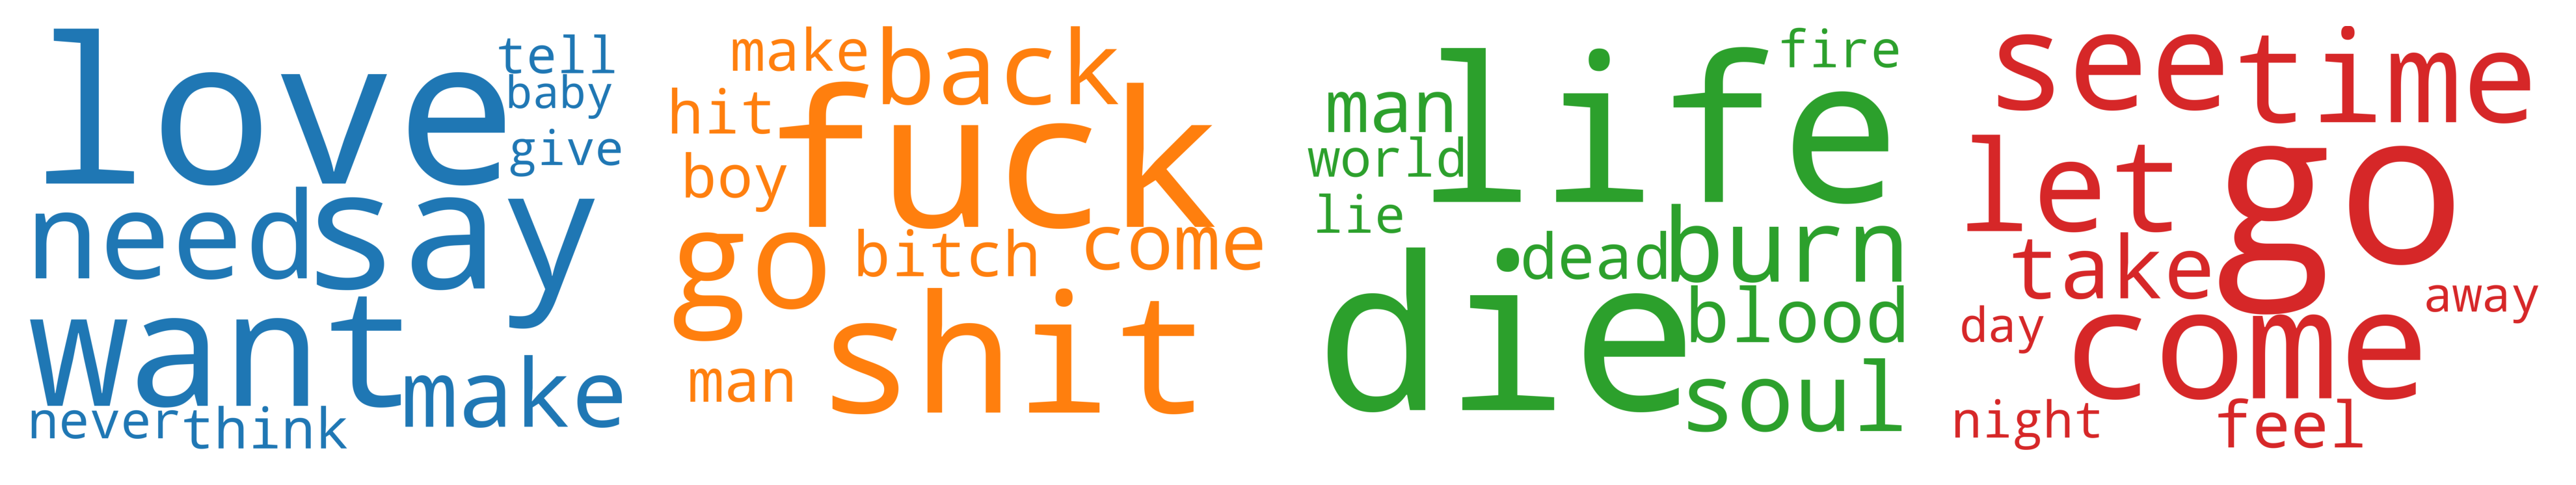

In [122]:
# Libraries used: matplotlib, pyplot, and wordcloud:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
#                   colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1,4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### 9. Save the dataset with all lyrics and audio features :

In [92]:
artist_lyrics_audio_dt.to_csv('../../Data/Artist_Tracks_Lyrics_Audio_Features/English_artist_5_tracks_with_lyrics_vader_nrc_moralStrength_lda_and_sp_features.csv',
   index = None)

#### 10. References:
1. Temporal Analysis and Visualisation of Music (Misael et al 2020): https://sol.sbc.org.br/index.php/eniac/article/view/12155
2. Evaluate Topic Models: Latent Dirichlet Allocation (LDA): https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
3. What’s in a Song? LDA Topic Modeling of over 120,000 Lyrics:
https://tim-denzler.medium.com/whats-in-a-song-using-lda-to-find-topics-in-over-120-000-songs-53785767b692
4. Evaluation of Topic Modeling: Topic Coherence: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/